In [ ]:
#Initialisation
import os
os.environ["JAX_PLATFORMS"] = "cpu"  # Disable GPU for JAX (Remove if you want to use GPU)

import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm, trange

# deteministic random numbers
np.random.seed(0)
random.seed(0)

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling, Sampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize

from LINKS.Optimization import DifferentiableTools, Tools

#load the curves to fit
target_curves = np.load('target_curves.npy')

PROBLEM_TOOLS = Tools( # we have to define this outside the class due to pymoo deepcopy limitations
            device='cpu' # device to run the optimization on
        )  
PROBLEM_TOOLS.compile() # compile the functions for faster runs

class mechanism_synthesis_optimization(ElementwiseProblem):

    # When intializing, set the mechanism size and target curve
    def __init__(self, target_curve, N = 5):
        self.N = N
        variables = dict()

        # The upper triangular portion of our NxN Connectivity Matrix consists of Nx(N-1)/2 boolean variables:
        for i in range(N):
            for j in range(i):
                variables["C" + str(j) + "_" + str(i)] = Binary()

        # We Delete C0_1 since we know node 1 is connected to the motor
        del variables["C0_1"]

        #Our position matrix consists of Nx2 real numbers (cartesian coordinate values) between 0 and 1
        for i in range(2*N):
            variables["X0" + str(i)] = Real(bounds=(0.0, 1.0))

        # Our node type vector consists of N boolean variables (fixed vs non-fixed)
        for i in range(N):
            variables["fixed_nodes" + str(i)] =  Binary(N)

        # Our target node is an integer between 1 and N-1, (any except the motor node).
        variables["target"] = Integer(bounds=(1,N-1))

        # Set up some variables in the problem class we inherit for pymoo
        # n_obj=number of objectives, n_constr=number of constraints
        # Our objectives are chamfer distance and material, and they both have constraints.
        super().__init__(vars=variables, n_obj=2, n_constr=2)

        # Store the target curve point cloud
        self.target_curve = target_curve


    def convert_1D_to_mech(self, x):
        N = self.N

        # Get target joints index
        target_idx = x["target"]

        # Build connectivity matrix from its flattened constitutive variables
        C = np.zeros((N,N))
        x["C0_1"] = 1

        for i in range(N):
            for j in range(i):
                # C[i,j] = x["C" + str(j) + "_" + str(i)]
                C[j,i] = x["C" + str(j) + "_" + str(i)]

        edges = np.array(np.where(C==1)).T
        
        # Reshape flattened position matrix to its proper Nx2 shape
        x0 = np.array([x["X0" + str(i)] for i in range(2*N)]).reshape([N,2])

        # Extract a list of Nodes that are fixed from boolean fixed_nodes vector
        fixed_joints = np.where(np.array([x["fixed_nodes" + str(i)] for i in range(N)]))[0].astype(int)

        #We fix the motor and original ground node as 0 and 1 respectively in this implementation
        motor=np.array([0,1])

        return x0, edges, fixed_joints, motor, target_idx

    def convert_mech_to_1D(self, x0, edges, fixed_joints, target_idx=None, **kwargs):
        # This function assumes motor to be [0, 1] our random mechanism generator automatically does this
        N = self.N

        # Initialize dictionary to store 1D representation of mechanism
        x = {}

        # Store target node value
        if target_idx is None:
            target_idx = x0.shape[0]-1 # Assume last node is the target if not specified
            
        x["target"] = target_idx

        # Store connectivity matrix in its flattened form
        C = np.zeros((N,N), dtype=bool)
        C[edges[:,0], edges[:,1]] = 1
        C[edges[:,1], edges[:,0]] = 1
       
        for i in range(N):
            for j in range(i):
                x["C" + str(j) + "_" + str(i)] = C[i,j]

        del x["C0_1"]
        
        # Store position matrix in its flattened form
        if x0.shape[0] != N:
            x0 = np.pad(x0, ((0, N - x0.shape[0]), (0, 0)), 'constant', constant_values=0)
            
        for i in range(2*N):
            x["X0" + str(i)] = x0.flatten()[i]

        # Store fixed nodes in boolean vector form
        for i in range(N):
            x["fixed_nodes" + str(i)] = (i in fixed_joints) or (i>=N)

        return x

    def _evaluate(self, x, out, *args, **kwargs):
        #Convert to mechanism representation
        x0, edges, fixed_joints, motor, target_idx = self.convert_1D_to_mech(x)
        
        # Simulate
        distance, material = PROBLEM_TOOLS(x0,
                                edges,
                                fixed_joints,
                                motor,
                                self.target_curve,
                                target_idx=target_idx
                            )

        out["F"] = np.array([distance, material])
        out["G"] = out["F"] - np.array([0.75, 10.0])  # Constraints: distance <= 0.75, material <= 10.0

from LINKS.Optimization import MechanismRandomizer
from LINKS.Visualization import MechanismVisualizer

from LINKS.Visualization import GAVisualizer
from LINKS.Kinematics import MechanismSolver
from LINKS.Geometry import CurveEngine

from pymoo.indicators.hv import HV
ga_visualizer = GAVisualizer()
solver = MechanismSolver(device='cpu')
curve_engine = CurveEngine(device='cpu')

In [ ]:
# Import the single helper we need here
from utils.mechanism_io import load_mechanisms
NUM_OF_NODES = 7
NUM_OF_MECH = 100
NUM_OF_GENERATIONS = 100

ONLY_FIRST_CURVE = False
if ONLY_FIRST_CURVE:
        curves = 0
else:
        curves = range(target_curves.shape[0])

results = []
for curve_index in curves:
        mechanisms = load_mechanisms(f'mechanisms_curve_{curve_index}_nodes_{NUM_OF_NODES}_mech_{NUM_OF_MECH}.npy')

        problem = mechanism_synthesis_optimization(target_curves[curve_index], N=NUM_OF_NODES)

        initial_population = [problem.convert_mech_to_1D(**mech) for mech in mechanisms]

        class sample_from_random(Sampling):
                def _do(self, problem, n_samples, **kwargs):
                        return np.array([initial_population[i%len(initial_population)] for i in range(n_samples)])

        F = problem.evaluate(np.array(initial_population))[0]
        print(f'Best Distance Performance In random population: {F[:,0].min()}')
        print(f'Best Material Performance In random population: {F[:,1].min()}')

        algorithm = NSGA2(pop_size=68,
                        sampling=sample_from_random(),
                        mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                        mutation=PolynomialMutation(prob=0.5),
                        eliminate_duplicates=MixedVariableDuplicateElimination())

        results.append(minimize(problem,
                        algorithm,
                        ('n_gen', NUM_OF_GENERATIONS),
                        verbose=True,
                        save_history=True,
                        seed=123
                        ))

        if not results[curve_index].X is None:
                #Specify reference point
                ref_point = np.array([0.75, 10.0])

                #Calculate Hypervolume
                ind = HV(ref_point)
                hypervolume = ind(results[curve_index].F)

                #Print and plot
                print('Hyper Volume ~ %f' %(hypervolume))
                ga_visualizer.plot_HV(results[curve_index].F, ref_point, objective_labels=['Distance', 'Material']) #use the plot_HV function from utils
        else:
                print('Did Not Find Solutions!!')



In [ ]:
results[1].X[0]

You can use this population to make a submission:

In [ ]:
from LINKS.CP import make_empty_submission, evaluate_submission

submission = make_empty_submission()

for curve_index in curves:
    # add out population to submission
    if not results[curve_index].X is None:
        print("number of curves:", results[curve_index].X.shape[0])
        for j in range(results[curve_index].X.shape[0]):
            if not isinstance(results[curve_index].X, dict):
                x0_member, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results[curve_index].X[j])
            else:
                x0_member, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results[curve_index].X)
            
            mech = {
                'x0': x0_member,
                'edges': edges,
                'fixed_joints': fixed_joints,
                'motor': motor,
                'target_joint': target_idx
            }
            
            k = curve_index + 1
            submission[f'Problem {k}'].append(mech)
            
evaluate_submission(submission)
print(evaluate_submission(submission))
np.save(f'my_full_submission_NUM_OF_NODES_{NUM_OF_NODES}_NUM_OF_MECH_{NUM_OF_MECH}_NUM_OF_GENERATIONS_{NUM_OF_GENERATIONS}_GA_only.npy', submission) 

You can see that GA is still not doing great with handling different mechanisms. You could adjust the initialization more, change mutation and cross-over functionality. So far however, we have not yet touched on gradient-based optimization. What if we took the solutions of GA and optimized for each of the objectives.

Now let's take the GA solutions from above and just optimize for the lowest distance. Then we will add the optimized solutions to the population we have and see how the hypervolume changes.

 **Note that if the material use exceeds 10 during this optimization the score will not change How could you address this?** 

In [ ]:
from LINKS.Optimization import DifferentiableTools

differentiable_optimization_tools = DifferentiableTools(
    device='cpu' # device to run the optimization on
)  
differentiable_optimization_tools.compile() # compile the functions for faster runs

curve_index: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

All members are done optimizing at step 39
Hypervolume before gradient optimization: 2.6862, after optimization: 3.0599, new GD: 2.9611
curve_index: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

All members are done optimizing at step 21
Hypervolume before gradient optimization: 2.4111, after optimization: 2.4200, new GD: 1.6591
curve_index: 2


  0%|          | 0/1000 [00:00<?, ?it/s]

All members are done optimizing at step 107
Hypervolume before gradient optimization: 3.2165, after optimization: 3.5201, new GD: 3.4719
curve_index: 3


  0%|          | 0/1000 [00:00<?, ?it/s]

All members are done optimizing at step 53
Hypervolume before gradient optimization: 3.6158, after optimization: 3.6386, new GD: 3.1311
curve_index: 4


  0%|          | 0/1000 [00:00<?, ?it/s]

All members are done optimizing at step 25
Hypervolume before gradient optimization: 1.8111, after optimization: 1.8176, new GD: 1.3770
curve_index: 5


  0%|          | 0/1000 [00:00<?, ?it/s]

All members are done optimizing at step 15
Hypervolume before gradient optimization: 1.4563, after optimization: 1.4563, new GD: 1.2440


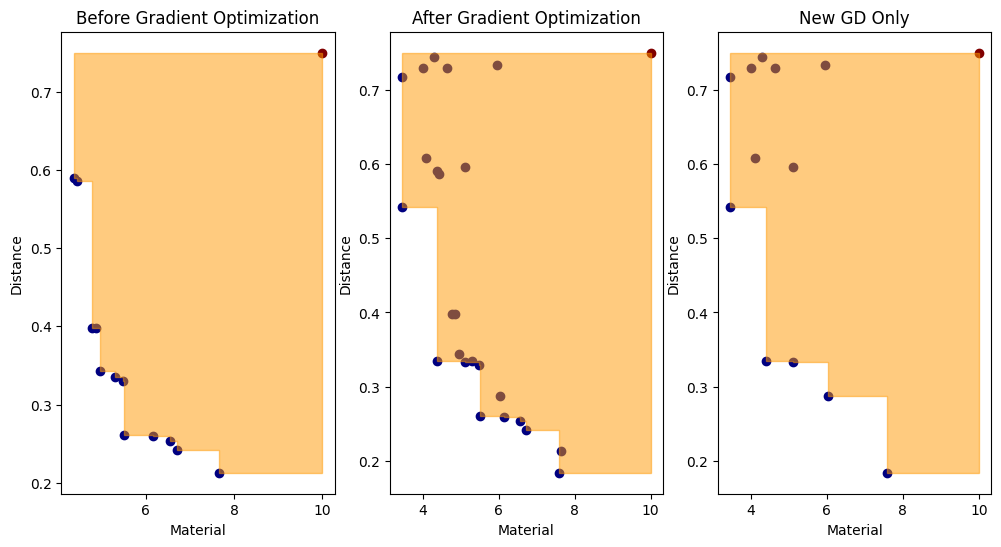

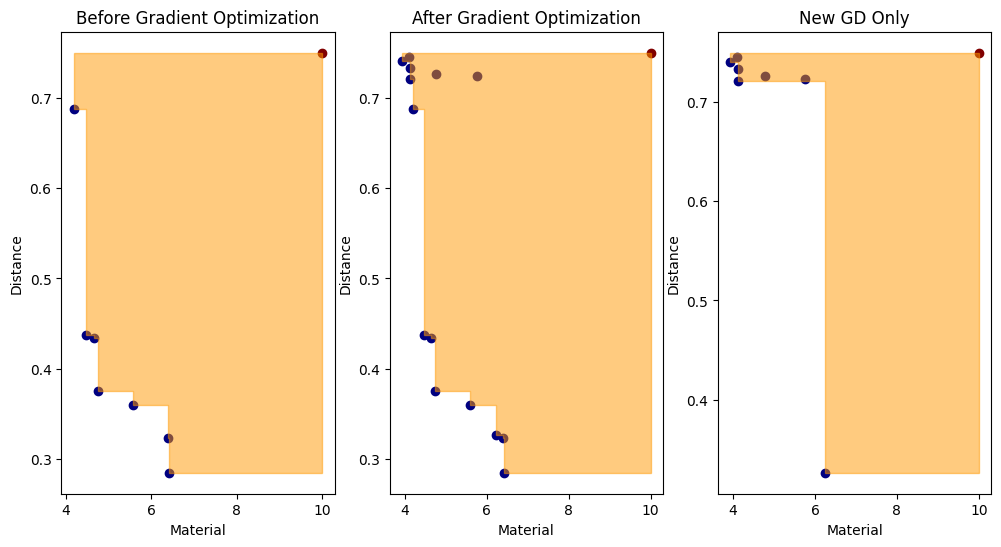

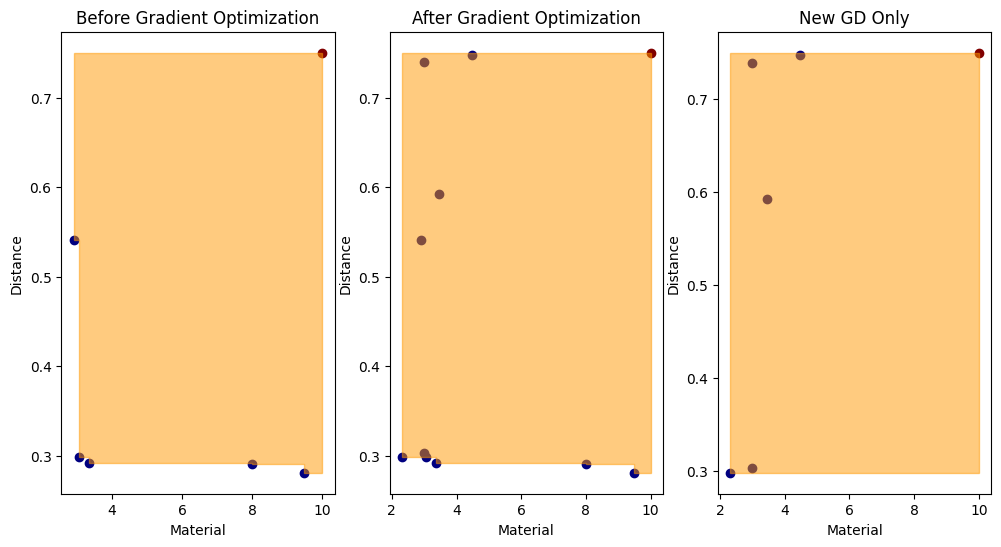

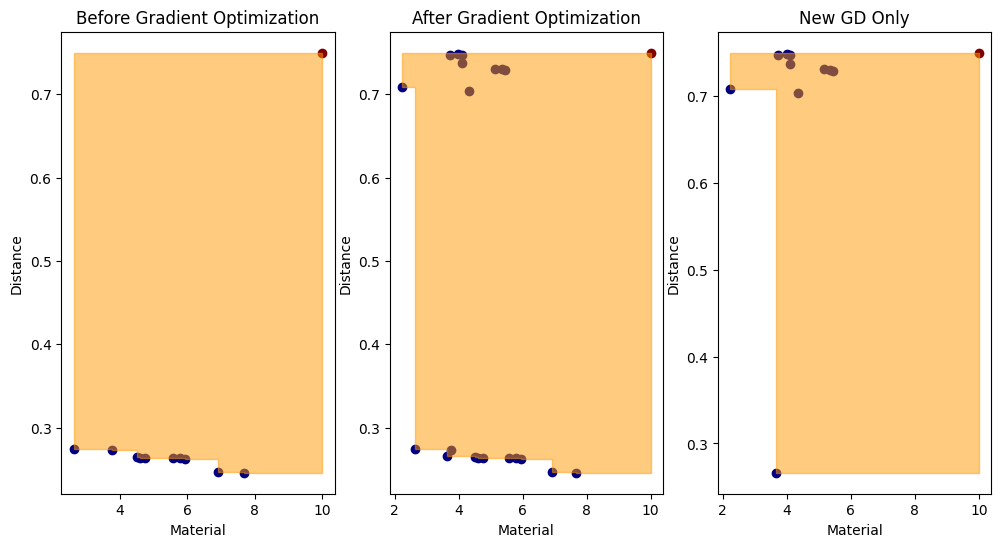

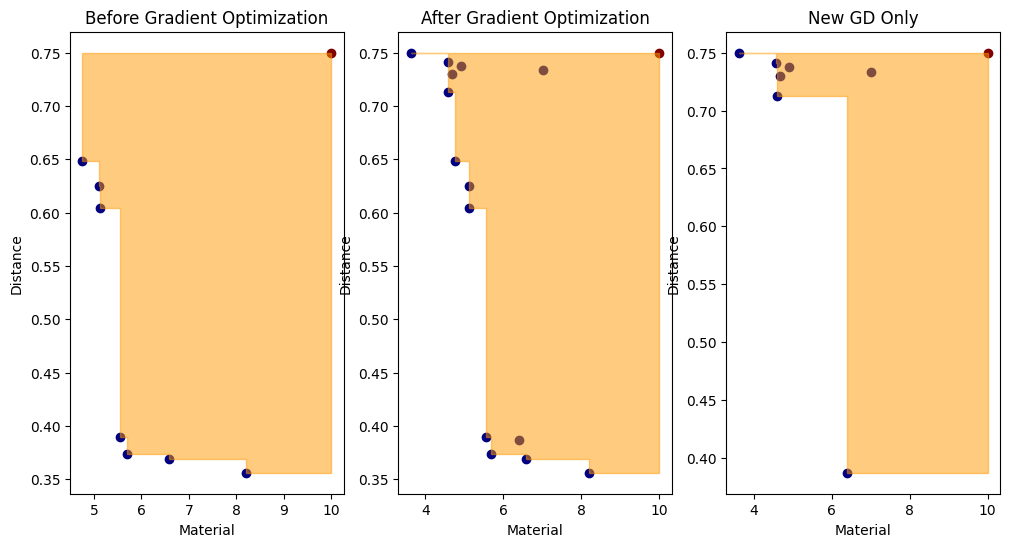

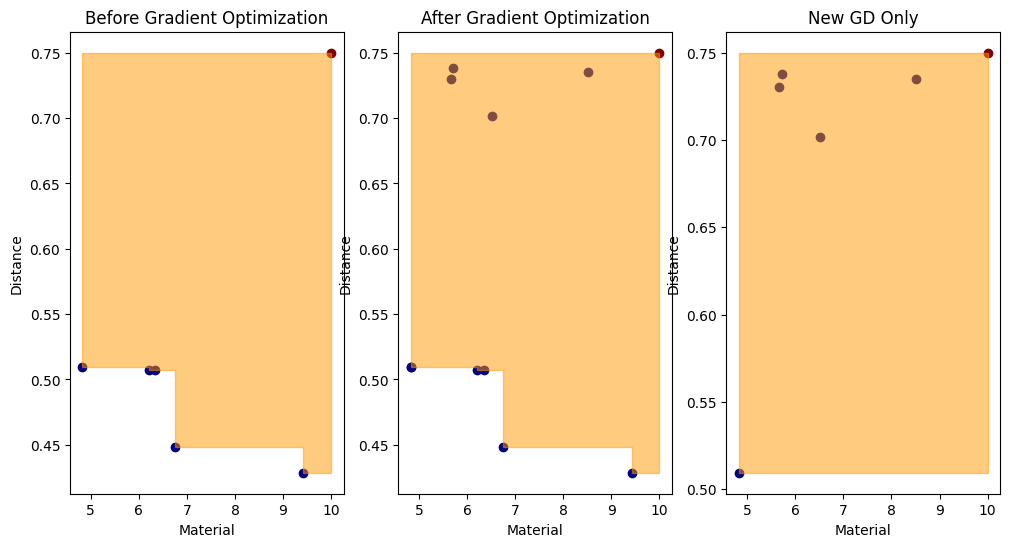

In [115]:
# lets make a batch from our GA results
for curve_index in curves:
    print("curve_index:", curve_index)
    x0s = []
    edges = []
    fixed_joints = []
    motors = []
    target_idxs = []
    if not results[curve_index].X is None:
        if not isinstance(results[curve_index].X, dict):
            for j in range(results[curve_index].X.shape[0]):
                x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = problem.convert_1D_to_mech(results[curve_index].X[j])
                x0s.append(x0_member)
                edges.append(edges_member)
                fixed_joints.append(fixed_joints_member)
                motors.append(motor_member)
                target_idxs.append(target_idx_member)
        else:
            x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = problem.convert_1D_to_mech(results[curve_index].X)
            x0s.append(x0_member)
            edges.append(edges_member)
            fixed_joints.append(fixed_joints_member)
            motors.append(motor_member)
            target_idxs.append(target_idx_member)

    x = x0s.copy()

    step_size = 4e-4
    n_steps = 1000

    # keep track of which members are done optimizing
    done_optimizing = np.zeros(len(x), dtype=bool)

    x_last = x.copy()

    for step in trange(n_steps):
        
        # get current distances, materials and gradients
        distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
            x,
            edges,
            fixed_joints,
            motors,
            target_curves[curve_index],
            target_idxs
        )
        
        # only update members that are valid and not done optimizing
        valids = np.where(np.logical_and(distances <= 0.75, materials <= 10.0))[0]
        invalids = np.where(~np.logical_and(distances <= 0.75, materials <= 10.0))[0]
        
        # if a member is invalid, revert to last step and mark as done optimizing
        for i in invalids:
            done_optimizing[i] = True
            x[i] = x_last[i]
        
        # keep a copy of last step
        x_last = x.copy()

        # update valid members
        for i in valids:
            if done_optimizing[i]:
                continue
            x[i] = x[i] - step_size * material_grads[i]#distance_grads[i]
            
        if np.all(done_optimizing):
            print(f'All members are done optimizing at step {step}')
            break

    combined_x0s = x0s + x
    combined_edges = edges + edges
    combined_fixed_joints = fixed_joints + fixed_joints
    combined_motors = motors + motors
    combined_target_idxs = target_idxs + target_idxs


    F = np.array(
        PROBLEM_TOOLS(
            combined_x0s,
            combined_edges,
            combined_fixed_joints,
            combined_motors,
            target_curves[curve_index],
            combined_target_idxs
        )).T

    F_before = np.array(
        PROBLEM_TOOLS(
            x0s,
            edges,
            fixed_joints,
            motors,
            target_curves[curve_index],
            target_idxs
        )).T
    
    F_new_GD = np.array(
        PROBLEM_TOOLS(
            x,
            edges,
            fixed_joints,
            motors,
            target_curves[curve_index],
            target_idxs
        )).T

    ref = np.array([0.75, 10.0])
    ind = HV(ref)

    hv_before = ind(F_before)
    hv_after = ind(F)
    hv_new_GD = ind(F_new_GD)

    print(f'Hypervolume before gradient optimization: {hv_before:.4f}, after optimization: {hv_after:.4f}, new GD: {hv_new_GD:.4f}')

    plt.subplots(1, 3, figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Before Gradient Optimization')
    ga_visualizer.plot_HV(F_before, ref, objective_labels=['Distance', 'Material'], ax=plt.gca())

    plt.subplot(1, 3, 2)
    plt.title('After Gradient Optimization')
    ga_visualizer.plot_HV(F, ref, objective_labels=['Distance', 'Material'], ax=plt.gca())

    plt.subplot(1, 3, 3)
    plt.title('New GD Only')
    ga_visualizer.plot_HV(F_new_GD, ref, objective_labels=['Distance', 'Material'], ax=plt.gca())

In [ ]:
# NOT DONE YET
from LINKS.CP import make_empty_submission, evaluate_submission

submission = make_empty_submission()

for curve_index in curves:
    # add out population to submission
    if not results[curve_index].X is None:
        print("number of mechanism:", results[curve_index].X.shape[0])
        for j in range(results[curve_index].X.shape[0]):
            if not isinstance(results[curve_index].X, dict):
                x0_member, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results[curve_index].X[j])
            else:
                x0_member, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results[curve_index].X)
            
            mech = {
                'x0': x0_member,
                'edges': edges,
                'fixed_joints': fixed_joints,
                'motor': motor,
                'target_joint': target_idx
            }
            
            k = curve_index + 1
            submission[f'Problem {k}'].append(mech)
            
evaluate_submission(submission)
print(evaluate_submission(submission))
np.save(f'my_full_submission_NUM_OF_NODES_{NUM_OF_NODES}_NUM_OF_MECH_{NUM_OF_MECH}_NUM_OF_GENERATIONS_{NUM_OF_GENERATIONS}_GA_only.npy', submission) 

here is how this differentiable class works:

In [ ]:
# distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
#     x0s,
#     edges,
#     fixed_joints,
#     motors,
#     target_curves[1],
#     target_idxs
# )

# print(distances, materials, distance_grads, material_grads )

**NOTE:** Sometimes the mechanisms are close to locking, which results in gradients exploding and in these cases the `DifferentiableTools` will return inifity results. You can ignore these since the `Tools` class will still simulate them eventhough the gradients are near singular.

Now we can combine these new memebers with the old and see how the hypervolume changes:

A small improvement. But this is just to give you an idea of what you can do when mixing optimization methods.

Now you should have a good idea of how to use the tools we have provided to you. Think about how you can improve each aspect of the optimization to achieve a higher score in you final submission. You are allowed also submit your teams best solutions to the leaderboard which we will announce soon and see how well you are doing compared other teams.

A few hints and ideas:
- Why not do some preprocessing to random mechanisms before running GA?
- Can you use the gradients of both functions in gradient based optimization? 
- Can you cycle through multiple optimization runs?
- Can you mix different kinds of GA? We showed how GA can be used for a single mechanism skeleton and how it can be used to also create the mechanisms?
- Can you modify the GA mutations and cross-over?
- Is there a more efficient representation of mechanisms we can use?
- Are there smarter gradient-based optimization methods?

# Appendix and Details

## Curve Distance Calculation

The target curves are provided to you as a sequence of points. The curves your mechanisms generate are then re-oriented compared to the target curves as we showed above. We measure the closeness of two point curves by computing the distance between the two curves with optimal alignment. This distance can be mathematically represented as:

$$
d_{OD}=\frac{2 \pi}{N}\min_{o_1 \in O_1, \alpha \in [0,2\pi)} \sum_{i=1}^N\left\|N(\mathbf{X}^{\text{coupler}}_{o_1(i)})\mathbf{R}(\alpha)-N(\mathbf{X}^{\text{target}})\right\|^2,
$$

$$\operatorname{N}(\mathbf{X})=\frac{\mathbf{X}- \overline{\mathbf{X}}}{\sqrt{\frac{\sum_{i=1}^N\|\mathbf{X}_i-\overline{\mathbf{X}}\|_2^2}{N}}}$$

Where $\mathbf{X}^{\text{coupler}}$ is the curve traced by the mechanism and $\mathbf{X}^{\text{target}}$ is the target curve and  $O_1$ is the set of all possible clockwise and counterclockwise orderings of a curve with $N$ ordered points and $\mathbf{R}(\alpha)$ is a $2\times2$ rotation matrix for angle $\alpha$, while $o_1(i)$ refers to the index of the $i$-th point in the set $o_1$. In practice, in our problem we may ignore the denominator in $N$ since we do not want to optimally rescale curves. The code we provide solves this optimization problem and retuns the distance value so you don't have to worry about this.

The other objective in this challenge problem is reducing the material used by the mechanism. This is the total length of all links in the mechanism. We have provided a function that makes this measurement for you using initial positions and adjacency matrix for a mechanism (The functions and useful tools are going to be described later).

### A Note On Scale Normalization

The functions that we saw in the starter notebool on curves, namely `compare_curves` and `visualize_comparison`, and `visualize_alignment` have a scaling option. An important input to the `CurveEngine` class is `normalize_scale`, which if set to `True` will rescale curves when comparing. In our problem we want this to be `False` since we care about the scale and material used in the problem. (We stress this distinction because the first component of the optimization demo had this rescaling turned on!)

In [ ]:
curve_processor = CurveEngine(
    normalize_scale=True, # whether to normalize the curve's scale (This would mean we do not care about the size of the curve but we do!)
    device='cpu' # device to run the processing on
)

curve_processor_unscaled = CurveEngine(
    normalize_scale=False, # do not normalize the scale of the curve (This would mean we care about the size of the curve too!)
    device='cpu'
)

curve_processor_unscaled.optimal_alignment

Let's go back to the simple fourbar we had and see what this means:

In [ ]:
visualizer = MechanismVisualizer()

# Define the variables for the mechanism
x0 = np.array([[0.3,0.2],
               [0.6,0.2],
               [0.3,0.3],
               [0.6,0.4],
               [0.4,0.5]])

# Define the connectivity of the mechanism
edges = np.array([[0,2],
                  [1,3],
                  [2,3],
                  [2,4],
                  [3,4]])

# Define the fixed nodes
fixed_joints = np.array([0,1])

# actuator
motor = np.array([0,2])

plt.figure(figsize=(5,5))
visualizer(x0, edges, fixed_joints, motor, ax=plt.gca())

In [ ]:
solver = MechanismSolver(
    device = 'cpu' # device to run the simulation on (cpu or gpu)
)

solution = solver(x0, edges, fixed_joints, motor)
traced_curve = solution[4]

In [ ]:
# lets compare to the first target curve
distance = curve_processor.compare_curves(traced_curve, target_curves[0])
unscaled_distance = curve_processor_unscaled.compare_curves(traced_curve, target_curves[0])

print(f"The scale normalized distance to target curve 1 is: {distance:.4f}")
print(f"The unnormalized distance to target curve 1 is: {unscaled_distance:.4f}") # This will be higher since do not normalize scale

Now let's visualize the alignment process with and without scale to understand what is going on:

In [ ]:
curve_processor.visualize_alignment(traced_curve, target_curves[0])
curve_processor.visualize_comparison(traced_curve, target_curves[0])

In [ ]:
curve_processor_unscaled.visualize_alignment(traced_curve, target_curves[0])
curve_processor_unscaled.visualize_comparison(traced_curve, target_curves[0])